In [ ]:
from collections import defaultdict
from metavision_core.event_io import RawReader
from hyperscope import config
from metavision_ml.preprocessing import timesurface
from metavision_sdk_core import RoiFilterAlgorithm, FlipXAlgorithm, PolarityFilterAlgorithm
from metavision_sdk_base import EventCDBuffer
from metavision_sdk_cv import (
    RotateEventsAlgorithm,
    SpatioTemporalContrastAlgorithm,
    SparseOpticalFlowAlgorithm,
    AntiFlickerAlgorithm,
    TrailFilterAlgorithm,
)
from math import pi
import gc
import h5py


class ProcessingPipeline:
    algorithms = []
    bufs = [None]

    def __init__(self, *algorithms):
        for algorithm in algorithms:
            self.append(algorithm)

    def append(self, algorithm):
        self.algorithms.append(algorithm)
        self.bufs.insert(-1, algorithm.get_empty_output_buffer())

    def insert(self, i, algorithm):
        self.algorithms.insert(i, algorithm)
        if i >= len(self.bufs):
            i = -1  # keep None as the last item
        self.bufs.insert(i, algorithm.get_empty_output_buffer())

    def process_events(self, evts):
        current_buf = evts
        next_buf = self.bufs[0]

        for i, a in enumerate(self.algorithms):
            a.process_events(current_buf, next_buf)
            current_buf = next_buf
            next_buf = self.bufs[i + 1]

        return self.bufs[-2].numpy(copy=True)


def transform_roi_90deg_ccw(x0, y0, x1, y1, image_height):
    new_x0 = image_height - y1
    new_y0 = x0
    new_x1 = image_height - y0
    new_y1 = x1
    return new_x0, new_y0, new_x1, new_y1


raw_file_path = str(config.DATA_DIR / "raw" / "metavision" / "recording_2024-07-30_13-51-19.raw")
reader = RawReader(raw_file_path)
height, width = reader.get_size()

x1, y1, x2, y2 = 265, 100, 430, 400
polarity_filter = PolarityFilterAlgorithm(polarity=1)  # only positive events
trail_filter = TrailFilterAlgorithm(height, width, 10)
anti_flicker_filter = AntiFlickerAlgorithm(height, width)
rot_algo = RotateEventsAlgorithm(height - 1, width - 1, -pi / 2)
flip_x_algo = FlipXAlgorithm(x2 - x1 - 1)
roi_filter = RoiFilterAlgorithm(
    *transform_roi_90deg_ccw(x1, y1, x2, y2, height), output_relative_coordinates=True
)


pipeline = ProcessingPipeline(
    polarity_filter, trail_filter, anti_flicker_filter, rot_algo, roi_filter
)

# polarity_buf = polarity_filter.get_empty_output_buffer()
# rot_buf = rot_algo.get_empty_output_buffer()
# flip_x_buf = flip_x_algo.get_empty_output_buffer()
# roi_buf = roi_filter.get_empty_output_buffer()
# events_buf = trail_filter_algorithm.get_empty_output_buffer()
# events_buf_2 = anti_flicker_filter.get_empty_output_buffer()


# def filter_events(evs):
#     polarity_filter.process_events(evs, polarity_buf)
#     trail_filter_algorithm.process_events(flip_x_buf, events_buf)
#     anti_flicker_filter.process_events(events_buf, roi_buf)
#     roi_filter.process_events(roi_buf, events_buf_2)
#     flip_x_algo.process_events(rot_buf, flip_x_buf)
#     rot_algo.process_events(polarity_buf, rot_buf)


start_time = int(38e6)
duration = int(2e6)  # capture 2s
stop_time = start_time + duration
accumulation_time = 10  # 10us
dt = 100_000  # batch length in us
exposure_time = 10_000  # exposure time of cmos in us
bins = duration // accumulation_time  # how many 10us bins in total duration
batches = duration // dt  # how many batches we need to process the total duration

from tqdm import tqdm

# Seek to
reader.reset()
reader.seek_time(start_time)
reader.clear_ext_trigger_events()  # not interested in earlier triggers
x0, y0, x1, y1 = transform_roi_90deg_ccw(x1, y1, x2, y2, height)
h = y1 - y0
w = x1 - x0

t_0 = None

buffer = []
pivot_ts = None

while not reader.is_done() and reader.current_time < stop_time:
    reader.load_delta_t(dt)

ext_evts = reader.get_ext_trigger_events()
ext_evts = ext_evts[ext_evts["p"] == 1]
reader.reset()
reader.seek_time(start_time)

ordered_pairs = []

v = np.zeros((exposure_time // accumulation_time, 1, h + 1, w + 1), dtype=np.float32)
with h5py.File("timesurfaces.h5", mode="w") as f:
    # Create extensible datasets
    timesurfaces_dataset = f.create_dataset(
        "timesurfaces",
        shape=(0, *v.shape),
        maxshape=(None, *v.shape),
        dtype=np.float32,
        chunks=(1, *v.shape),  # Each chunk is one timesurface
    )
    timestamps_dataset = f.create_dataset(
        "timestamps",
        shape=(0,),
        maxshape=(None,),
        dtype=np.int64,
        chunks=(1000,),  # Adjust chunk size as needed
    )

    for e in tqdm(ext_evts, desc="Aligning CMOS Exposures"):
        if reader.is_done():
            break
        reader.seek_time(e["t"] - exposure_time // 2)
        evts = reader.load_delta_t(exposure_time)
        # filter_events(evts)
        evts = pipeline.process_events(evts)
        if len(evts) == 0:
            continue  # Skip this timestamp if no events
        evts["t"] -= evts["t"][0]
        evts["p"] = 0
        timesurface(evts, v, exposure_time)

        # Extend datasets
        timesurfaces_dataset.resize(timesurfaces_dataset.shape[0] + 1, axis=0)
        timestamps_dataset.resize(timestamps_dataset.shape[0] + 1, axis=0)

        # Add new data
        timesurfaces_dataset[-1] = v
        timestamps_dataset[-1] = e["t"]

    f.attrs["exposure_time"] = exposure_time
    f.attrs["accumulation_time"] = accumulation_time

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.morphology import binary_dilation, disk
from metavision_ml.preprocessing.viz import filter_outliers
import h5py
from skimage.filters import threshold_otsu
from skimage.measure import regionprops, label
from scipy.optimize import linear_sum_assignment
from filterpy.kalman import KalmanFilter
from collections import defaultdict
from scipy.interpolate import interp1d
from datetime import datetime

debug_file = open("timesurface.log", mode="w")


class InterpolatedTrack:
    def __init__(self, initial_pos, initial_vel, initial_time, interpolation_points=100):
        # Initialize Kalman filter for tracking
        # Why: Kalman filter provides optimal estimation of object state (position and velocity)
        # in the presence of noise and uncertainty
        self.kf = KalmanFilter(dim_x=4, dim_z=4)
        self.kf.x = np.array(
            [initial_pos[0], initial_pos[1], initial_vel[0], initial_vel[1]]
        ).reshape(4, 1)
        # State transition matrix: assumes constant velocity model
        self.kf.F = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])
        # Measurement matrix: we can observe all state variables
        self.kf.H = np.eye(4)
        # Initial state covariance: high uncertainty in initial state
        self.kf.P *= 1000.0
        # Measurement noise covariance: relatively low, as measurements are quite accurate
        self.kf.R *= 0.1
        # Process noise covariance: accounts for deviations from constant velocity model
        self.kf.Q *= 0.1
        self.last_update_time = datetime.now()
        self.last_update_type = "INIT"
        # Store track data for interpolation
        # Why: To enable smooth trajectory reconstruction between key frames
        self.interpolation_points = interpolation_points
        self.positions = [initial_pos]
        self.times = [initial_time]
        self.velocities = []
        self.key_positions = [initial_pos]
        self.key_times = [initial_time]
        self.intermediate_positions = []
        self.intermediate_times = []

    def get_track(self):
        # Return the key positions and times of the track
        return np.array(self.key_positions), np.array(self.key_times)

    def predict(self, current_time):
        # Predict the current state using Kalman filter
        self.kf.predict()
        predicted_state = self.kf.x.flatten()

        # Refine prediction using intermediate frames if available
        # Why: To incorporate more recent information and improve prediction accuracy
        if self.intermediate_times and self.intermediate_times[-1] > self.key_times[-1]:
            last_key_time = self.key_times[-1]
            last_key_pos = self.key_positions[-1]
            last_inter_time = self.intermediate_times[-1]
            last_inter_pos = self.intermediate_positions[-1]

            # Calculate velocity using last key frame and last intermediate frame
            velocity = (last_inter_pos - last_key_pos) / (last_inter_time - last_key_time)

            # Predict position based on this velocity
            time_since_last_inter = current_time - last_inter_time
            refined_prediction = last_inter_pos + velocity * time_since_last_inter

            # Combine Kalman filter prediction with refined prediction
            # Why: To balance between model-based prediction and recent observations
            alpha = 0.7  # Weight for Kalman filter prediction
            combined_prediction = alpha * predicted_state[:2] + (1 - alpha) * refined_prediction

            return np.concatenate([combined_prediction, predicted_state[2:]])

        return predicted_state

    def update_key(self, measurement, time):
        # Update the Kalman filter with a new key frame measurement
        self.kf.update(measurement)
        self.positions.append(self.kf.x[:2].flatten())
        self.velocities.append(self.kf.x[2:].flatten())
        self.times.append(time)
        self.key_positions.append(measurement[:2])
        self.key_times.append(time)
        self.last_update_time = datetime.now()
        self.last_update_type = "KEYFRAME"

    def update_intermediate(self, position, time):
        # Store intermediate frame information
        # Why: To refine trajectory between key frames
        self.intermediate_positions.append(position)
        self.intermediate_times.append(time)
        self.last_update_time = datetime.now()
        self.last_update_type = "INTERMEDIATE"

    def get_interpolated_track(self):
        if len(self.positions) < 2:
            logger.debug(f"Track has less than 2 positions. Returning original data.")
            return np.array(self.positions), np.array(self.times)

        times = np.array(self.times)
        positions = np.array(self.positions)

        logger.debug(f"Original time range: {times[0]} to {times[-1]}")
        logger.debug(f"Number of original positions: {len(positions)}")

        interp_times = np.linspace(times[0], times[-1], num=self.interpolation_points)
        
        interp_x = np.interp(interp_times, times, positions[:, 0])
        interp_y = np.interp(interp_times, times, positions[:, 1])

        interp_positions = np.column_stack((interp_x, interp_y))

        logger.debug(f"Interpolated time range: {interp_times[0]} to {interp_times[-1]}")
        logger.debug(f"Number of interpolated positions: {len(interp_positions)}")

        return interp_positions, interp_times



# Utility functions


def plot_all_v(file_path):
    """
    Plot the mean of all timesurfaces in the HDF5 file.
    Why: To visualize the overall activity in the event data.
    """
    with h5py.File(file_path) as h5_file:
        img = np.mean(h5_file["timesurfaces"][0:100], axis=(0, 1, 2))
        plt.imshow(img)
        plt.show()
        plt.close()


def get_hdf5_size(file_path):
    """
    Get the number of timestamps in the HDF5 file.
    Why: To determine the total number of frames for progress tracking.
    """
    with h5py.File(file_path, "r") as h5_file:
        return len(h5_file["timestamps"])


def read_hdf5_datasets(file_path):
    """
    Generator to read timesurfaces and timestamps from HDF5 file.
    Why: To efficiently process large datasets without loading everything into memory.
    """
    with h5py.File(file_path, "r") as h5_file:
        timesurfaces = h5_file["timesurfaces"]
        timestamps = h5_file["timestamps"]
        num_items = len(timestamps)

        for i in range(num_items):
            timesurface = timesurfaces[i]
            timestamp = timestamps[i]
            yield timesurface, timestamp


def compute_optical_flow(time_surface):
    """
    Compute optical flow using gradient of time surface.
    Why: To estimate motion between frames, which is crucial for object tracking.
    """
    grad_y, grad_x = np.gradient(time_surface)
    np.nan_to_num(grad_x, False)
    np.nan_to_num(grad_y, False)
    return grad_x, grad_y


def find_centroids(image):
    """
    Find centroids of objects in the image using Otsu's thresholding.
    Why: To identify potential objects of interest in the event data.
    """
    thresh = threshold_otsu(image)
    binary = image > thresh
    footprint = disk(radius=3)
    binary = binary_dilation(binary, footprint)
    labeled = label(binary)

    regions = regionprops(labeled)
    centroids = np.array([region.centroid for region in regions if region.perimeter > 60])

    return centroids


def hungarian_matching(tracks, detections, current_time, max_distance=50):
    """
    Perform Hungarian matching between tracks and detections.
    Why: To associate current detections with existing tracks, crucial for multi-object tracking.
    """
    cost_matrix = np.zeros((len(tracks), len(detections)))
    for i, track in enumerate(tracks):
        predicted_state = track.predict(current_time)
        for j, detection in enumerate(detections):
            cost_matrix[i, j] = np.linalg.norm(
                predicted_state[:2] - detection[:2]
            )  # Only consider position for matching

    # Perform Hungarian matching
    # Why: To find the optimal assignment of detections to tracks
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    matches = []
    unmatched_tracks = set(range(len(tracks)))
    unmatched_detections = set(range(len(detections)))

    for r, c in zip(row_ind, col_ind):
        if cost_matrix[r, c] <= max_distance:
            matches.append((r, c))
            unmatched_tracks.remove(r)
            unmatched_detections.remove(c)

    return matches, list(unmatched_tracks), list(unmatched_detections)


def process_timesurfaces(
    file_path,
    subset_size=10,
    total_duration=10000,
    max_unmatched_frames=5,
    interpolation_points=100,
):
    """
    Process timesurfaces to track objects and generate interpolated trajectories.
    Why: To convert raw event data into meaningful object trajectories.
    """
    tracks = []
    interpolated_positions = []
    interpolated_times = []
    half_duration = total_duration // 2
    subset_duration = total_duration // subset_size
    unmatched_count = defaultdict(int)

    key_frame_buffer = []
    key_frame_time = None

    for v, t in tqdm(
        read_hdf5_datasets(file_path),
        total=get_hdf5_size(file_path),
        desc="Processing timesurfaces",
    ):
        for i in range(len(v)):
            v_ = v[i]
            current_time = t - half_duration + i * (total_duration / len(v))

            if len(key_frame_buffer) == 0:
                key_frame_time = current_time

            key_frame_buffer.append(v_[0])

            if len(key_frame_buffer) == subset_size:
                logger.debug("Processing key frame")
                # Process key frame
                # Why: Key frames are used for major updates in tracking
                mean_v = np.sum(key_frame_buffer, axis=0)
                key_frame_buffer = []

                if mean_v.max() == 0:
                    continue
                mean_v = mean_v / mean_v.max()
                mean_v = filter_outliers(mean_v, 2)

                flow_x, flow_y = compute_optical_flow(mean_v)
                flow_mag = np.sqrt(flow_x**2 + flow_y**2)
                try:
                    centroids = find_centroids(flow_mag)
                    logger.debug(f"Found {len(centroids)} centroids")
                except Exception as e:
                    print(f"Exception occurred: {e}")
                    continue

                if len(centroids) > 0:
                    centroid_velocities = [
                        (flow_x[int(c[0]), int(c[1])], flow_y[int(c[0]), int(c[1])])
                        for c in centroids
                    ]
                    logger.debug(f"Calculated {len(centroid_velocities)} velocities")
                    if not tracks:
                        # Initialize tracks if none exist
                        tracks = [
                            InterpolatedTrack(
                                centroid, velocity, key_frame_time, interpolation_points
                            )
                            for centroid, velocity in zip(centroids, centroid_velocities)
                        ]
                    else:
                        # Match existing tracks to new detections
                        predicted_states = [track.predict(key_frame_time) for track in tracks]
                        matches, unmatched_tracks, unmatched_detections = hungarian_matching(
                            tracks, centroids, key_frame_time
                        )

                        # Reset unmatched_count for all tracks at the start of each key frame processing
                        for idx in range(len(tracks)):
                            unmatched_count[idx] = 0

                        # After matching
                        for track_idx, detection_idx in matches:
                            # Update the track
                            measurement = np.array(
                                [
                                    centroids[detection_idx][0],
                                    centroids[detection_idx][1],
                                    centroid_velocities[detection_idx][0],
                                    centroid_velocities[detection_idx][1],
                                ]
                            )
                            tracks[track_idx].update_key(measurement, key_frame_time)
                            # Reset the unmatched count for matched tracks
                            unmatched_count[track_idx] = 0

                        # Increment unmatched_count only for unmatched tracks
                        for idx in unmatched_tracks:
                            unmatched_count[idx] += 1

                        # Log the unmatched counts
                        logger.debug(f"Unmatched counts after processing: {unmatched_count}")

                        # When creating a new track
                        for idx in unmatched_detections:
                            new_track = InterpolatedTrack(
                                centroids[idx],
                                centroid_velocities[idx],
                                key_frame_time,
                                interpolation_points,
                            )
                            tracks.append(new_track)
                            unmatched_count[len(tracks) - 1] = (
                                0  # Initialize unmatched count for the new track
                            )
                        logger.debug(
                            f"Found a total of {len(tracks)} tracks. Of which {len(unmatched_detections)} are unmatched"
                        )
                        logger.debug(f"Tracks before filtering: {len(tracks)}")
                        logger.debug(f"Unmatched counts before filtering: {unmatched_count}")
                        # Remove tracks that have been unmatched for too long
                        tracks = [
                            track
                            for idx, track in enumerate(tracks)
                            if unmatched_count[idx] < max_unmatched_frames
                        ]

                        # Update unmatched_count dictionary to remove entries for deleted tracks
                        unmatched_count = {
                            idx: count
                            for idx, count in enumerate(unmatched_count.values())
                            if idx < len(tracks)
                        }

                        logger.debug(f"Tracks after filtering: {len(tracks)}")
                        logger.debug(f"Unmatched counts after filtering: {unmatched_count}")
                        for idx, track in enumerate(tracks):
                            logger.debug(
                                f"Remaining track {idx}: last_update_time = {track.last_update_time}, last_update_kind =  {track.last_update_type}"
                            )
            else:
                logger.debug(f"Processing intermediate frames")
                # Process intermediate frame
                # Why: Intermediate frames refine trajectories between key frames
                mean_v = v_[0]
                if mean_v.max() == 0:
                    continue
                mean_v = mean_v / mean_v.max()
                mean_v = filter_outliers(mean_v, 2)

                flow_x, flow_y = compute_optical_flow(mean_v)
                flow_mag = np.sqrt(flow_x**2 + flow_y**2)
                try:
                    centroids = find_centroids(flow_mag)
                except Exception as e:
                    logger.error(f"Exception occurred: {str(e)}")
                    continue

                logger.debug(f"N Tracks: {len(tracks)}")
                for track in tracks:
                    if len(centroids) > 0:
                        closest_centroid = min(
                            centroids, key=lambda c: np.linalg.norm(c - track.positions[-1])
                        )
                        track.update_intermediate(closest_centroid, current_time)

    # Interpolate and store tracks
    # Why: To generate smooth, high-resolution trajectories for final output
    all_positions, all_times = [], []
    logger.info("Interpolating Tracks")
    for track in tqdm(tracks, desc="Interpolating Tracks"):
        interp_positions, interp_times = track.get_interpolated_track()
        all_positions.extend(interp_positions)
        all_times.extend(interp_times)
        
    return all_positions, all_times


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d_centroids(
    positions, times, ext_times, sample_rate=1, time_tolerance=1000, start_time=None, end_time=None
):
    """
    Create a 3D scatter plot of centroid positions over time with planes at specific times,
    restricted to a specific time range if specified.

    :param positions: List of numpy arrays, each containing x, y coordinates for tracks
    :param times: List of numpy arrays, each containing time values for tracks
    :param ext_times: List or array of times at which to add planes
    :param sample_rate: Integer, plot every nth point to reduce density (default: 1, plot all points)
    :param time_tolerance: Float, tolerance for finding points near the planes (default: 1000)
    :param start_time: Float, start of the time range to plot (default: None, plot from the beginning)
    :param end_time: Float, end of the time range to plot (default: None, plot until the end)
    """
    # Flatten positions and times arrays
    #positions = np.concatenate(positions)
    #times = np.concatenate([times, times])
    positions = np.array(positions)[::sample_rate]
    times = np.array(times)[::sample_rate]

    # Ensure ext_times is a numpy array
    ext_times = np.array(ext_times)
    
    # Filter the data based on the specified time range
    if start_time is not None or end_time is not None:
        start_time = start_time if start_time is not None else np.min(times)
        end_time = end_time if end_time is not None else np.max(times)
        time_mask = (times >= start_time) & (times <= end_time)
        positions = positions[time_mask, :]
        times = times[time_mask]
        ext_times = ext_times[(ext_times >= start_time) & (ext_times <= end_time)]

    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    print(f"Time range: {np.min(times)} to {np.max(times)}")

    # Plot the scatter plot
    scatter = ax.scatter(
        positions[:, 0],
        positions[:, 1],
        times,
        c=times,
        cmap="viridis",
        s=10,
        alpha=0.6,
        label="Centroids",
    )

    # Prepare for planes
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    X, Y = np.meshgrid(np.linspace(x_min, x_max, 10), np.linspace(y_min, y_max, 10))

    # Plot the planes
    for ext_time in ext_times:
        Z = np.full_like(X, ext_time)
        ax.plot_surface(X, Y, Z, alpha=0.2, color="red")

    # Set labels and title
    ax.set_xlabel("X position")
    ax.set_ylabel("Y position")
    ax.set_zlabel("Time")
    ax.set_title(f"Centroid Positions Over Time ({start_time} to {end_time})")

    # Add a color bar
    cbar = fig.colorbar(scatter, ax=ax, label="Time")

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()

In [23]:
import sys
# Remove any default handlers
logger.remove()

# Add a handler for stderr (console) that only shows warnings and errors
logger.add(sys.stderr, level=30)

# Add a handler for the file that logs everything (including debug, info, warnings, and errors)
logger.add("timesurfaces.log", rotation="500 MB", level=10)

positions, times = process_timesurfaces('timesurfaces.h5', subset_size=200)

Processing timesurfaces:   0%|          | 0/70 [00:00<?, ?it/s]

Interpolating Tracks: 100%|██████████| 36/36 [00:00<00:00, 549.73it/s]


Time range: 39001153.75757576 to 39099949.81818182


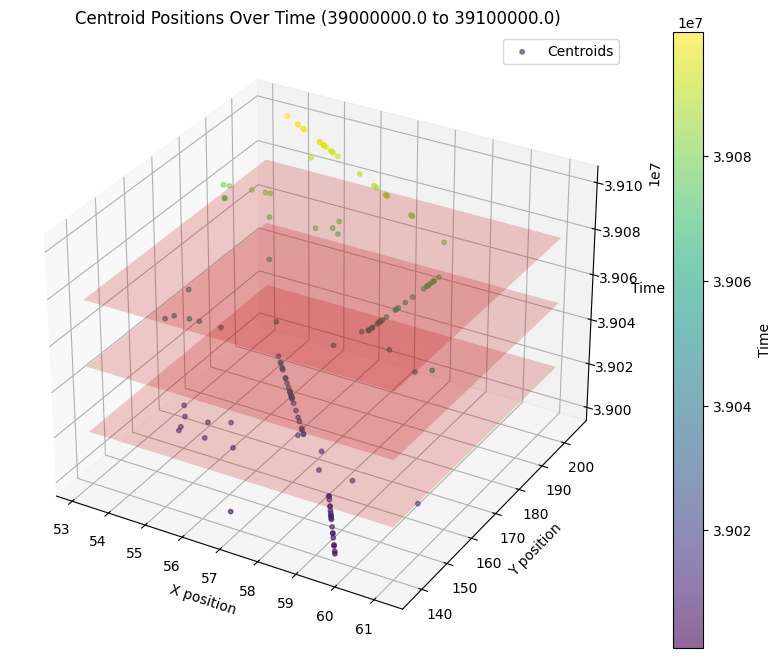

In [24]:
import h5py
with h5py.File('timesurfaces.h5', mode='r') as f:
    plot_3d_centroids(positions, times, ext_times=f['timestamps'], start_time=3.9e7, end_time=3.91e7)
 

In [25]:
positions

[array([15.8594041, 63.1461825]),
 array([16.12952437, 79.2152786 ]),
 array([16.00476191, 93.07385407]),
 array([ 17.19935751, 110.19217731]),
 array([ 14.52852196, 120.64906371]),
 array([ 12.17944188, 135.89277652]),
 array([ 14.16549392, 148.28605085]),
 array([ 15.12008681, 166.9957392 ]),
 array([ 14.92507496, 180.42011772]),
 array([ 14.9178171 , 195.27096885]),
 array([ 15.04324779, 205.85570595]),
 array([ 11.87944899, 222.92470705]),
 array([ 10.79052399, 223.85026923]),
 array([ 27.29565398, 198.83814444]),
 array([ 43.80078398, 173.82601965]),
 array([ 60.30591398, 148.81389485]),
 array([ 76.81104397, 123.80177006]),
 array([93.31617397, 98.78964527]),
 array([109.82130397,  73.77752048]),
 array([126.32643396,  48.76539568]),
 array([142.83156396,  23.75327089]),
 array([151.53953314,  10.87263599]),
 array([149.44309595,  31.27674666]),
 array([154.89552556,  30.0404225 ]),
 array([141.98807988,  40.24689579]),
 array([152.79838356,  80.28713426]),
 array([154.43262814, 